<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment2/MachineLearningAssignment2SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libaries and data

# Loading libaries and Data in

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_rows", None)

In [2]:
#uploading and reading RESTler output file with test cases
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t', delimiter=None, header='infer', names=None, index_col=None)

Saving Sentiment140.tenPercent.sample.tweets.tsv to Sentiment140.tenPercent.sample.tweets.tsv


In [3]:
sns.set_style('dark')
import matplotlib as mpl
mpl.style.use(['https://gist.githubusercontent.com/BrendanMartin/01e71bb9550774e2ccff3af7574c0020/raw/6fa9681c7d0232d34c9271de9be150e584e606fe/lds_default.mplstyle'])
mpl.rcParams.update({"figure.figsize": (8,6), "axes.titlepad": 22.0})

# Data Exploration

Check Size of Data

In [6]:
print(dataset.head())
print(dataset.info())

   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Check if any missing values

In [21]:
print(dataset.isnull().values.any())

False


In [20]:
print("Number of duplicates before dropping:  " + str(len(dataset[dataset.duplicated()])))


dataset.drop_duplicates(keep = False, inplace = True)
print("Number of duplicates after dropping:  " + str(len(dataset[dataset.duplicated()])))

Number of duplicates before dropping:  553
Number of duplicates after dropping:  0


Checking if data balanced

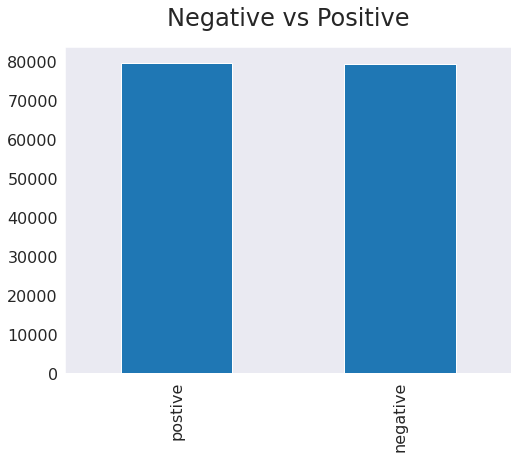

In [32]:
# df.rename(columns = {'y':'target'}, inplace = True)
dataset['sentiment_label'] = dataset.sentiment_label.apply(lambda x: "postive" if x == 4 else "negative")

dataset.sentiment_label.value_counts().plot(kind="bar", title="Negative vs Positive");

# Data Pre-processing

Remove stop words

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stop_words = ['-','The','What','_','&']
stop_words.extend(new_stop_words)

dataset['tweet_text_processed'] = dataset['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Stem the words

In [25]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()
dataset['tweet_text_processed_stemmed'] = [ps.stem(word) for word in dataset['tweet_text_processed']]

new_stop_words = ['#anxiety','anxieti','anxiety']
stop_words.extend(new_stop_words)
dataset['tweet_text_processed_stemmed'] = dataset['tweet_text_processed_stemmed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Sentiment Analysis

Word Plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

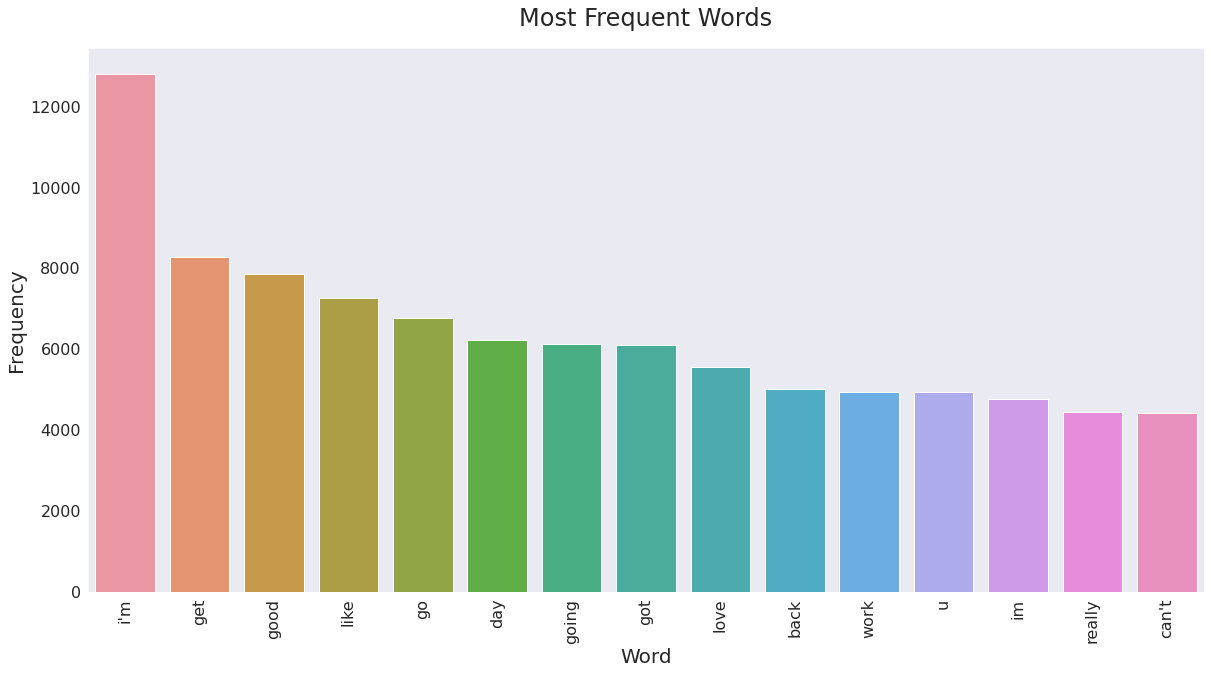

In [27]:
from collections import Counter
import seaborn as sns

most_common_words_text = Counter(" ".join(dataset['tweet_text_processed_stemmed'] .str.lower()).split()).most_common(15)
df_words_text = pd.DataFrame.from_records(most_common_words_text, columns=['Word','Frequency'])
fig, ax = plt.subplots()
sns.barplot(x='Word',y='Frequency',data=df_words_text,ax=ax).set_title("Most Frequent Words")
fig_text = plt.gcf()
fig_text.set_size_inches(20, 10)
plt.xticks(rotation=90)

# Machine Learning